## Electrical Substation Detection

The task of this competition is to develop a Machine learning-based software using 
open source tools. Further extract Electrical Substations from high resolution satellite 
data,  and  submit  a  paper (PDF) describing  the  techniques  employed  in  solving  the 
problem.  

In [129]:
import numpy as np
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
import os
from glob import glob
import random
import itertools
from skimage import util
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

## Dataset

The  contestants will be provided with  the 
Training Dataset 
of 100 Satellite  data 
chips of ~1m resolution for training. Each image chip will have one electrical substation 
feature. Set of Points and Polygons AOI will also be provided for training the Machine 
learning  network.  A 
Testing  Dataset 
of 20  satellite  data  chip’s  mosaic,  containing 
substations and other features will be provided for testing. The Tutorial
 Links 
will be 
provided for online learning of the API’s and libraries.

## Observation

The bounding box or the observation file is not a square bounding box, it is a shape file and hence the case needs to be treated as an Image Segmentation Problem.


## DataSet Preparation

We need to generate masks from shapefile to get a required label for each pixel.

In [130]:
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models

import segmentation_models as sm

!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

import albumentations as A

import cv2

import tensorflow.keras as keras

import tensorflow as tf
tf.config.run_functions_eagerly(True)
# from keras.utils import np_utils

env: SM_FRAMEWORK=tf.keras
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-t857k8ot
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-t857k8ot


In [131]:
x_train_dir = '../input/electrical-substation-detection/train/image_chips'
y_train_dir = '../input/electrical-substation-detection/train/labels'

x_valid_dir = '../input/electrical-substation-detection/validation/image_chips'
y_valid_dir = '../input/electrical-substation-detection/validation/labels'

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [132]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
        Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    
    CLASSES = ['nodetect', 'es']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = mask/mask.max()
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch[0], batch[1]
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

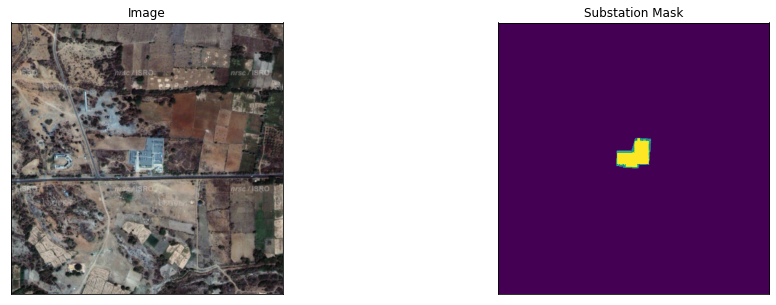

In [133]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['NoDetect', 'ES'])

image, mask = dataset[10] # get some sample
visualize(
    image=image, 
    substation_mask=mask[..., 1].squeeze(),
)

In [134]:
IMG_SIZE = 512


def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def normalize_albumenation(x, **kwargs):
    return x

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=30, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, always_apply=True, border_mode=0),
        A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),

#         A.IAAAdditiveGaussianNoise(p=0.2),
        # A.IAAPerspective(p=0.5),

#         A.OneOf(
#             [
#                 A.CLAHE(p=1),
#                 A.RandomBrightness(p=1),
#                 A.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

        # A.OneOf(
        #     [
        #         A.IAASharpen(p=1),
        #         A.Blur(blur_limit=3, p=1),
        #         A.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

#         A.OneOf(
#             [
#                 A.RandomContrast(p=1),
#                 A.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #  A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True)
        # A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=normalize_albumenation)
    ]
    return A.Compose(_transform)

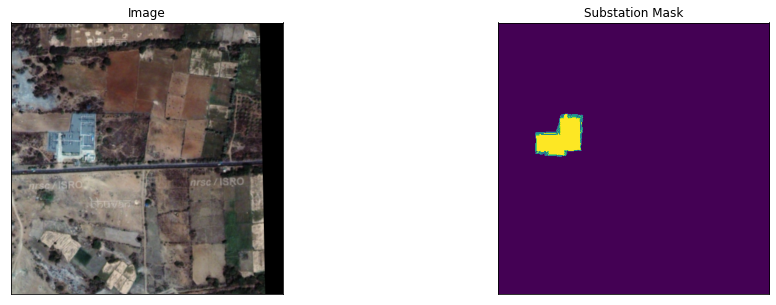

In [135]:
#  Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['nodetect', 'es'], augmentation=get_training_augmentation())

image, mask = dataset[10] # get some sample
visualize(
    image=image, 
    substation_mask=mask[..., 1].squeeze(),
)

In [136]:
BACKBONE = 'resnet34'
BATCH_SIZE = 8
CLASSES = ['es']
LR = 0.0001
EPOCHS = 150
version = 8

preprocess_input = sm.get_preprocessing(BACKBONE)

In [137]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

tf.keras.backend.clear_session()
#create mode
# model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)
# model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet') #'imagenet')#, encoder_freeze=True)
# model = sm.Unet( classes=n_classes, activation=activation)


In [138]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
jacard_loss = sm.losses.JaccardLoss()

# total_loss =dice_loss + (1*focal_loss) + (1*jacard_loss) + (1*bce_loss)
total_loss = dice_loss+jacard_loss+focal_loss


# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [139]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/kaggle/working/best_model_v%d.h5'%version, save_weights_only=True,save_best_only=True, mode='min', verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, verbose=1),
]

with open('/kaggle/working/ModelSummary_v%d.txt'%version, 'w') as f:
    model.summary(print_fn=f.write)
# model.summary()

In [140]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/150
10/10 [==============================] - 6s 566ms/step - loss: 2.0969 - iou_score: 0.1282 - f1-score: 0.2261 - val_loss: 3.6238 - val_iou_score: 0.1418 - val_f1-score: 0.2333

Epoch 00001: val_loss improved from inf to 3.62384, saving model to /kaggle/working/best_model_v8.h5
Epoch 2/150
10/10 [==============================] - 5s 537ms/step - loss: 1.7141 - iou_score: 0.1677 - f1-score: 0.2850 - val_loss: 4.8174 - val_iou_score: 0.1545 - val_f1-score: 0.2490

Epoch 00002: val_loss did not improve from 3.62384
Epoch 3/150
10/10 [==============================] - 6s 583ms/step - loss: 1.6364 - iou_score: 0.3622 - f1-score: 0.5230 - val_loss: 5.1261 - val_iou_score: 0.1417 - val_f1-score: 0.2312

Epoch 00003: val_loss did not improve from 3.62384
Epoch 4/150
10/10 [==============================] - 5s 539ms/step - loss: 1.5457 - iou_score: 0.5785 - f1-score: 0.7283 - val_loss: 4.0522 - val_iou_score: 0.1630 - val_f1-score: 0.2632

Epoch 00004: val_loss did not improve from 3.

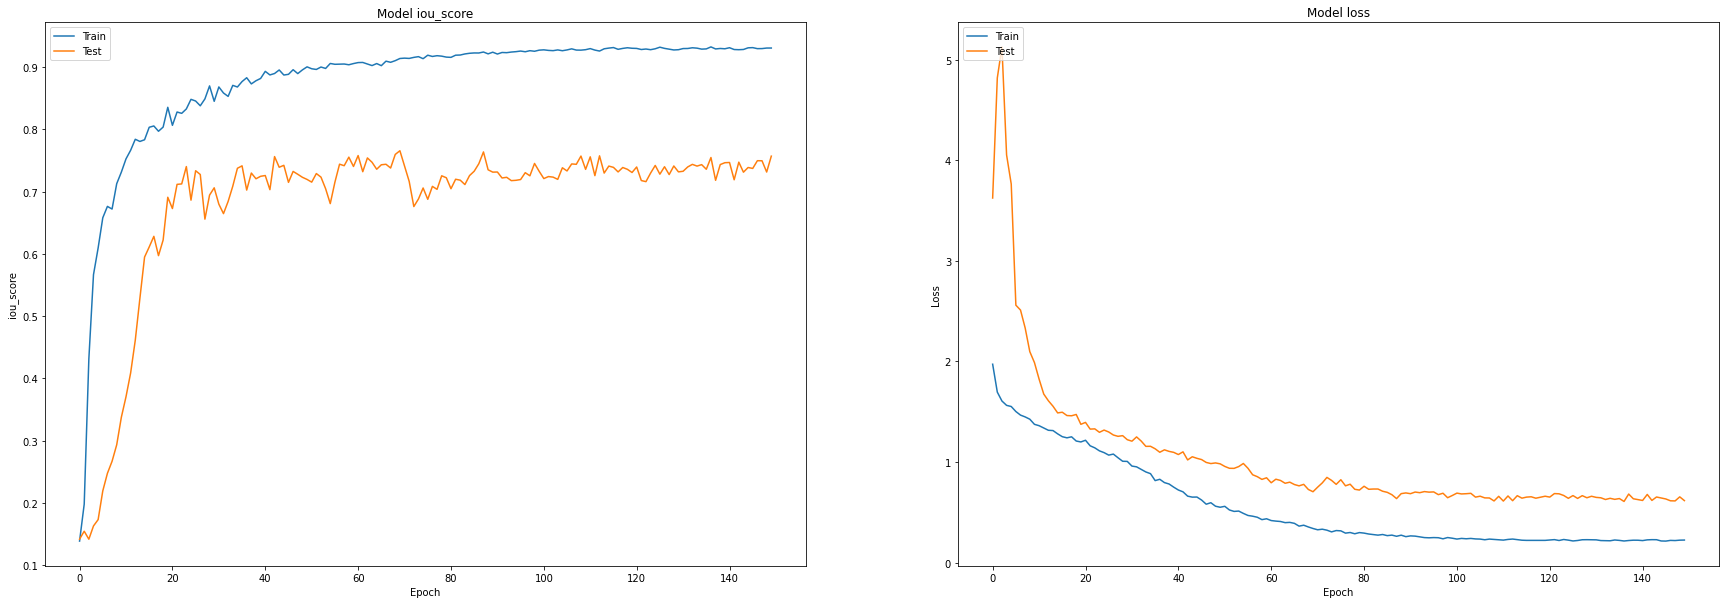

In [141]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('/kaggle/working/TrainingSummary_v%d.jpg'%version)
plt.show()


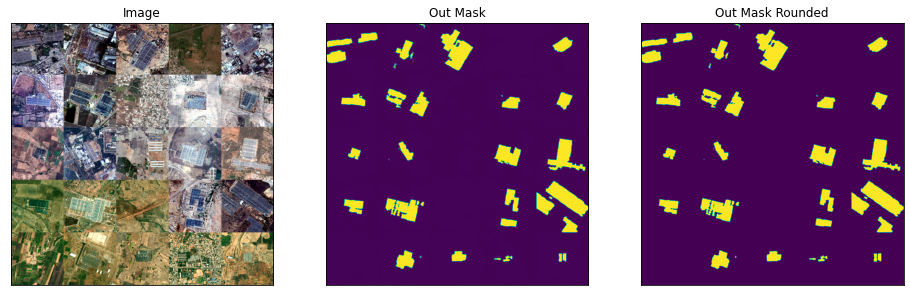

In [142]:
test_img = imread('../input/electrical-substation-detection/test/mosaic_test.jpg')
out_mask = np.zeros((test_img.shape[0], test_img.shape[1]))

img_x, img_y = 768, 768

# test_model = keras.models.load_model('/kaggle/working/best_model_v%d.h5'%version)
model.load_weights('/kaggle/working/best_model_v%d.h5'%version)
for i in range(5):
    for j in range(5):
        image = np.zeros((768,768,3))
        image[:750, :750] = test_img[i*750:(i+1)*750, j*750:(j+1)*750]
        image = get_preprocessing(preprocessing_fn=preprocess_input)(image=image)['image']
        image = np.expand_dims(image, axis=0)
        out_mask[i*750:(i+1)*750, j*750:(j+1)*750] = model.predict(image)[0,:750,:750,0]


visualize(
    image=denormalize(test_img.squeeze()),
    out_mask=out_mask,
    out_mask_rounded=out_mask.round()
)

plt.imsave('/kaggle/working/OutMaskv%d.jpg'%version, out_mask.round(), cmap='gray')
np.save("/kaggle/working/out_mask_v%d.npy"%version, np.array(out_mask))

## Individual Testing

If the original test image can be seen comprising of 5 x 5 tiles of 750 x 750 images, we can see individual results below by altering `i` for row index and `j` for column index of composing 5x5 = 25 images.

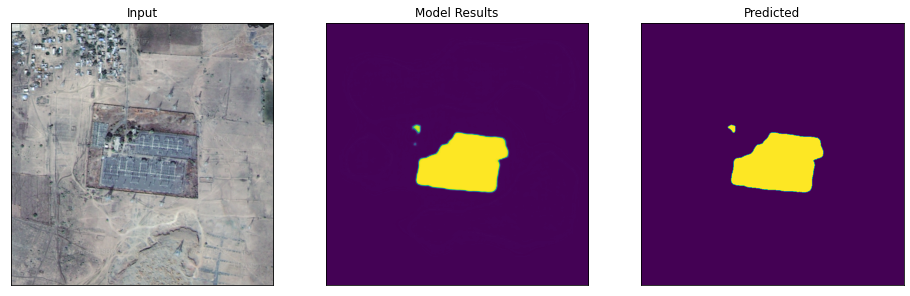

In [143]:
i=1
j=3

image = np.zeros((768,768,3))

image[:750, :750] = test_img[i*750:(i+1)*750, j*750:(j+1)*750]
image = get_preprocessing(preprocessing_fn=preprocess_input)(image=image)['image']
image = np.expand_dims(image, axis=0)
out_mask= model.predict(image)[0,:750,:750,0]

visualize(Input=test_img[i*750:(i+1)*750, j*750:(j+1)*750], Model_Results=out_mask, Predicted=out_mask.round())